In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [168]:
# sales_data = pd.read_excel('C:/Users/michelj8/Downloads/Sales_Transactions_Dataset_Weekly.xlsx',sheet_name = 'Sheet1')
sales_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/Sales_Transactions_Dataset_Weekly.xlsx', sheet_name = 'Sheet1')
sales_data = sales_data.set_index('Product_Code')

In [169]:
def exp_smooth(Y,alpha):
    smooth = [Y[0]]
    for t in range(1, len(Y)):
        smooth.append( (1-alpha)*Y[t] + (alpha)* smooth[t-1])    
    return smooth

def objective(Y,alpha,penalty):
    data = pd.DataFrame({'Y':Y, 'est':exp_smooth(Y,alpha)})
    data['est'] = data['est'].shift(1)
    data = data.dropna()
    
    sum_squares = np.square(data['Y'] - data['est']).sum() + penalty*abs(alpha)
    return sum_squares

def minimal_alpha(Y, penalty, grid_size):
    alphas = np.linspace(0,1,grid_size)
    
    min_alpha = 0.0
    min_obj = np.square( np.diff( np.array(Y)) ).sum()
    
    for alpha in alphas:
        sum_squares = 0.0
        forecast = Y[0]
        
        for t in range(1, len(Y)):
            sum_squares = sum_squares + np.square(Y[t]-forecast)
            forecast = (1-alpha)*Y[t] + alpha*forecast
        
        obj = sum_squares + penalty*alpha
        
        if obj < min_obj:
            min_alpha = alpha
            min_obj = obj
            
    return min_alpha

# Alpha SES for all data

In [5]:
alpha_df = pd.DataFrame( columns = ['product','alpha'])
alpha_df['product'] = sales_data.index.values
alpha_df['alpha'] = alpha_df['product'].apply(lambda s: minimal_alpha(sales_data.loc[s],0.0,100) )

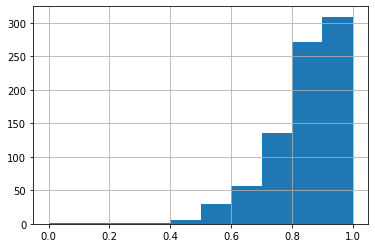

In [6]:
alpha_df['alpha'].hist()

In [7]:
len(alpha_df.query('alpha < .5'))/len(alpha_df)

0.012330456226880395

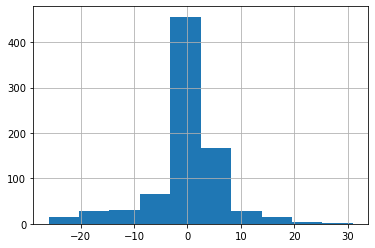

In [8]:
(sales_data['W51'] - sales_data['W0']).hist()

# LASSO Analysis for 1

In [170]:
Y = sales_data.loc['P16']
sample_size = len(Y)

Y_train = Y[0:round(sample_size/2.5)].values
Y_validate = Y[round(sample_size/2.5):2*round(sample_size/2.5)].values
Y_test = Y[2*round(sample_size/2.5):].values

train_index = range(0,round(sample_size/2.5))
validate_index = range(round(sample_size/2.5), 2* round(sample_size/2.5))
test_index = range(2*round(sample_size/2.5),sample_size)

penalty_list = np.linspace(0,750,50)
# penalty_list = np.linspace(0,400,50)

cv_df = pd.DataFrame(columns =['penalty','train_alpha','validate_sse','test_sse'])
cv_df['penalty'] = penalty_list
cv_df = cv_df.set_index('penalty')

for pen in penalty_list:
    train_alpha = minimal_alpha(Y_train,pen,200)
    
    exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
    exp_df['exp'] = exp_df['exp'].shift(1) 
    exp_df = exp_df.reset_index()
    
    val_sse = np.square(exp_df.loc[validate_index]['Y'] - exp_df.loc[validate_index]['exp']).sum()
    test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
    
    cv_df.loc[pen] = [train_alpha,val_sse,test_sse]
    
cv_df = cv_df.reset_index()


opt_lambda = cv_df[cv_df['validate_sse']== cv_df['validate_sse'].min()]['penalty'].values[0]

alpha_list = []
oos_error_list = []
for pen in [0.0, opt_lambda]:
    train_alpha = minimal_alpha(np.append(Y_train,Y_validate),pen, 200)
    
    exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
    exp_df['exp'] = exp_df['exp'].shift(1) 
    exp_df = exp_df.reset_index()
    test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()
    
    alpha_list.append(train_alpha)
    oos_error_list.append(test_sse)

In [171]:
outcome_df =  pd.DataFrame({'model':['exp_smooth','lasso'], 'alpha':alpha_list, 'sse':oos_error_list})
outcome_df.set_index('model')

,alpha,sse
model,,
exp_smooth,0.673367,546.481580
lasso,0.577889,518.216867


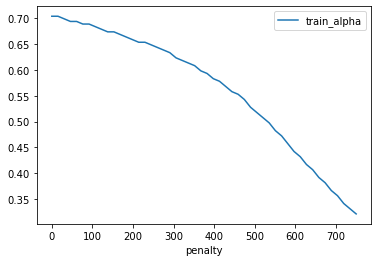

In [172]:
cv_df.plot(x = 'penalty',y='train_alpha')

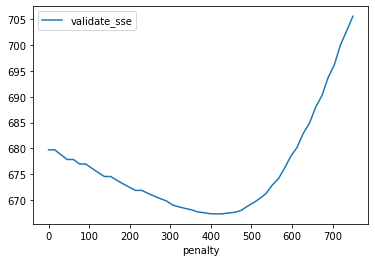

In [173]:
cv_df.plot(x = 'penalty', y='validate_sse')

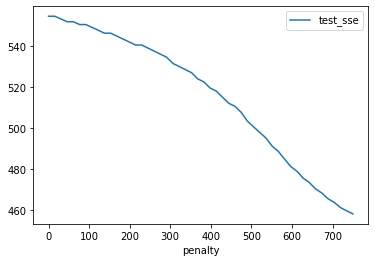

In [174]:
cv_df.plot(x = 'penalty',y='test_sse')

In [175]:
cv_df.tail()

,penalty,train_alpha,validate_sse,test_sse
45,688.775510,0.366834,693.69,465.656
46,704.081633,0.356784,696.154,463.876
47,719.387755,0.341709,700.043,461.353
48,734.693878,0.331658,702.764,459.771
49,750.000000,0.321608,705.587,458.27


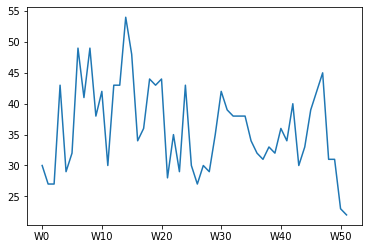

In [176]:
Y.plot()

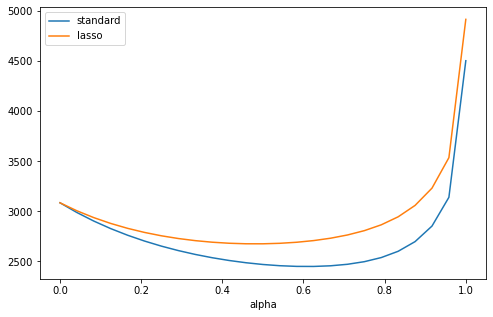

In [177]:
objective_df = pd.DataFrame(columns = ['alpha','standard','opt_lasso'])
objective_df['alpha'] = np.linspace(0,1,25)

objective_df['standard'] = objective_df['alpha'].apply(lambda s: objective(Y,s,0.0))
objective_df['lasso'] = objective_df['alpha'].apply(lambda s: objective(Y,s,opt_lambda))


fig, ax = plt.subplots(figsize = (8,5))
objective_df.plot(x= 'alpha', y='standard', ax = ax)
objective_df.plot(x= 'alpha', y='lasso', ax = ax)

## Analysis for all series

In [219]:
test_df = pd.DataFrame(columns = ['alpha_ses','alpha_lasso','opt_lambda','sse_ses','sse_lasso'])

popular_product_index = sales_data[ sales_data.sum(axis = 1) > 1000].index

# for prod in sales_data.index.values:
for prod in popular_product_index:
    Y = sales_data.loc[prod]
    sample_size = len(Y)

    Y_train = Y[0:round(sample_size/2.5)].values
    Y_validate = Y[round(sample_size/2.5):2*round(sample_size/2.5)].values
    Y_test = Y[2*round(sample_size/2.5):].values


    train_index = range(0,round(sample_size/2.5))
    validate_index = range(round(sample_size/2.5), 2* round(sample_size/2.5))
    test_index = range(2*round(sample_size/2.5),sample_size)


    penalty_list = np.linspace(0,750,50)
    # penalty_list = np.linspace(0,400,50)

    cv_df = pd.DataFrame(columns =['penalty','train_alpha','validate_sse','test_sse'])
    cv_df['penalty'] = penalty_list
    cv_df = cv_df.set_index('penalty')

    for pen in penalty_list:
        train_alpha = minimal_alpha(Y_train,pen,200)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()

        val_sse = np.square(exp_df.loc[validate_index]['Y'] - exp_df.loc[validate_index]['exp']).sum()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        cv_df.loc[pen] = [train_alpha,val_sse,test_sse]

    cv_df = cv_df.reset_index()


    opt_lambda = cv_df[cv_df['validate_sse']== cv_df['validate_sse'].min()]['penalty'].values[0]

    alpha_list = []
    oos_error_list = []
    for pen in [0.0, (2.0**(.33))*opt_lambda]:
        train_alpha = minimal_alpha(np.append(Y_train,Y_validate),pen, 200)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        alpha_list.append(train_alpha)
        oos_error_list.append(test_sse)

    
    test_df.loc[prod] = alpha_list +[opt_lambda] +oos_error_list

In [220]:
test_df.head()

,alpha_ses,alpha_lasso,opt_lambda,sse_ses,sse_lasso
P10,0.899497,0.839196,459.183673,171.164151,175.404563
P15,0.567839,0.567839,0.000000,412.663430,412.663430
P16,0.673367,0.542714,413.265306,546.481580,507.907778
P17,0.618090,0.472362,750.000000,272.483540,276.953528
P18,0.748744,0.321608,750.000000,309.047014,388.603607


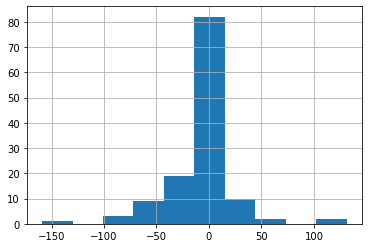

In [221]:
test_df['sse_delta'] = (test_df['sse_ses'] - test_df['sse_lasso'])
test_df['sse_delta'].hist()

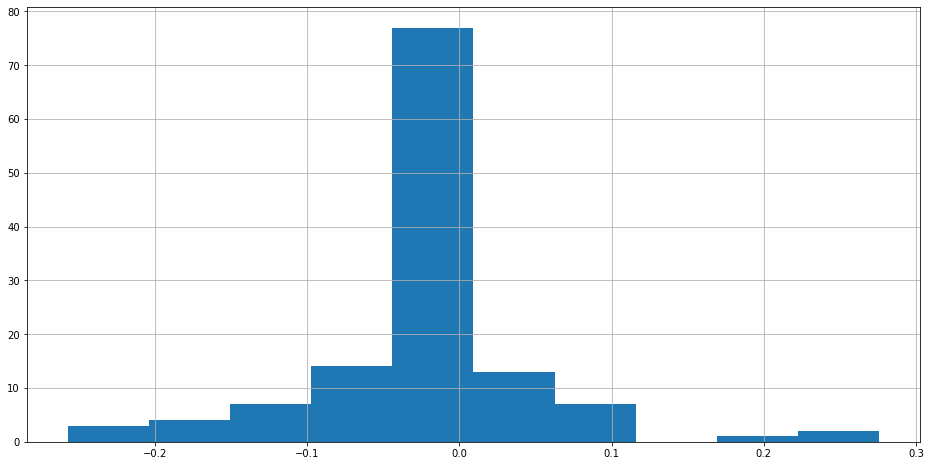

In [222]:
fig, ax = plt.subplots(figsize = (16,8))

(test_df['sse_delta']/test_df['sse_ses']).hist(ax = ax)

In [223]:
len(test_df.query('sse_delta < 0'))/len(test_df)

0.4765625

In [224]:
len(test_df.query('sse_delta > 0'))/len(test_df)

0.21875

In [225]:
len(test_df.query('sse_delta == 0'))/len(test_df)

0.3046875

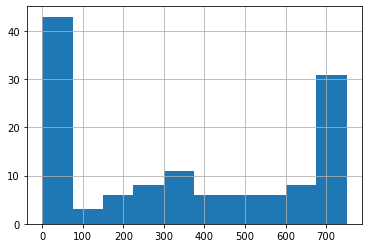

In [226]:
test_df['opt_lambda'].hist()

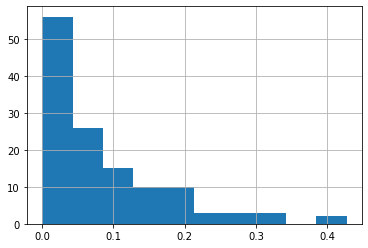

In [227]:
(test_df['alpha_ses'] - test_df['alpha_lasso']).hist()

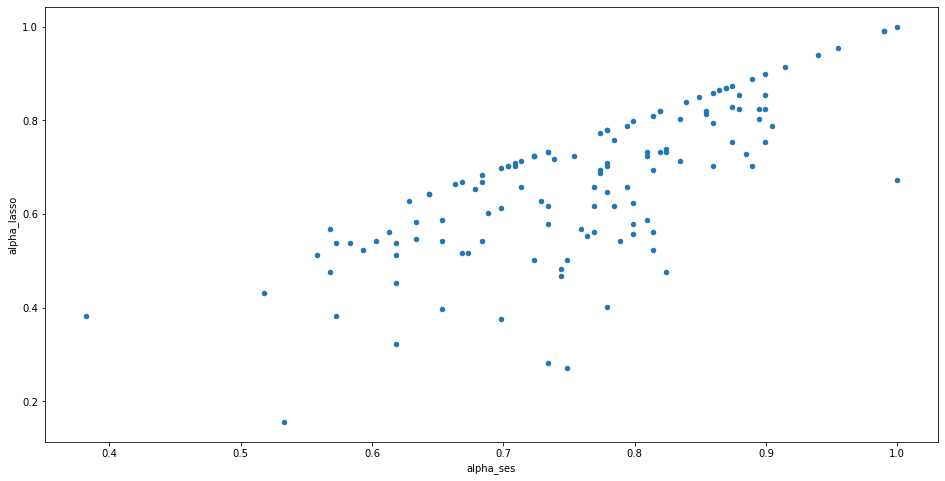

In [211]:
fig, ax = plt.subplots(figsize = (16,8))

test_df.plot.scatter(x='alpha_ses',y='alpha_lasso', ax = ax)

[Text(0, 0, '.4'),
 Text(0, 0, '.5'),
 Text(0, 0, '.6'),
 Text(0, 0, '.7'),
 Text(0, 0, '.8'),
 Text(0, 0, '.9'),
 Text(0, 0, '1')]

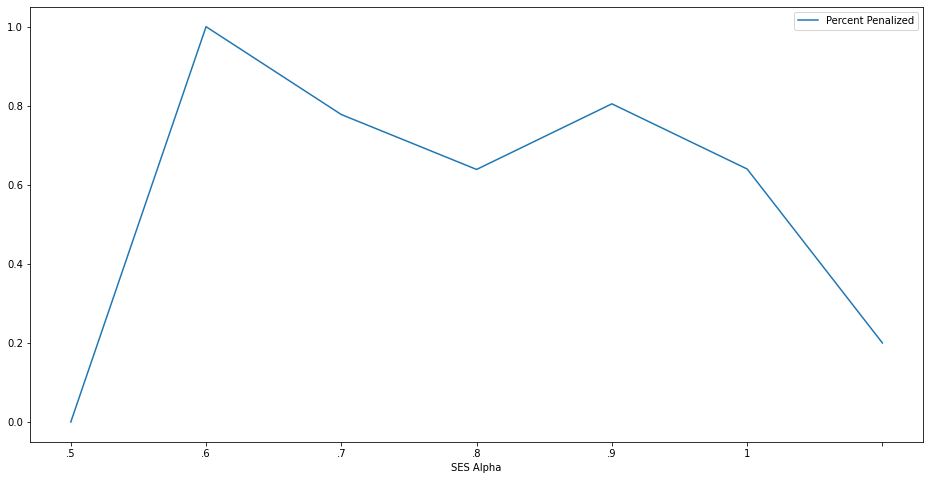

In [212]:
test_df['ses_bucket']=  test_df['alpha_ses'].apply(lambda s: round(10*s))
test_df['penalized'] = 1*(test_df['opt_lambda']>0)

fig, ax = plt.subplots(figsize = (16,8))
test_df[['ses_bucket','penalized']].groupby('ses_bucket').mean().plot(ax = ax)

ax.legend(['Percent Penalized'])
ax.set_xlabel('SES Alpha')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['.4','.5','.6','.7','.8','.9','1']
ax.set_xticklabels(labels)

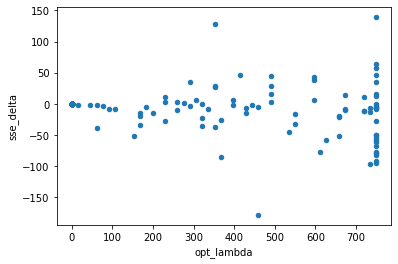

In [213]:
test_df.plot.scatter(x='opt_lambda',y='sse_delta')

In [214]:
len(popular_product_index)

128

# Multistep forecasts

In [217]:
multi_step_df = pd.DataFrame(columns = range(1,7))

for prod in popular_product_index:
    Y = sales_data.loc[prod]
    sample_size = len(Y)
    test_index = range(2*round(sample_size/2.5),sample_size)


    alpha_ses = test_df.loc[prod,'alpha_ses']
    alpha_lasso = test_df.loc[prod,'alpha_lasso']
    
    for h in range(1,7):
        ses_exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha_ses)})
        ses_exp_df['exp'] = ses_exp_df['exp'].shift(h) 
        ses_exp_df = ses_exp_df.reset_index() 
        ses_error = np.square(ses_exp_df.loc[test_index]['Y'] - ses_exp_df.loc[test_index]['exp']).sum()
        
        lasso_exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,alpha_lasso)})
        lasso_exp_df['exp'] = lasso_exp_df['exp'].shift(h) 
        lasso_exp_df= lasso_exp_df.reset_index()
        lasso_error = np.square(lasso_exp_df.loc[test_index]['Y'] - lasso_exp_df.loc[test_index]['exp']).sum()
        
        multi_step_df.loc[prod,h] =  (ses_error - lasso_error)

In [218]:
for h in range(1,7):
    print(h)
    print(sum(1*(multi_step_df[h] > 0))/len(multi_step_df), sum(1*(multi_step_df[h] >= 0))/len(multi_step_df))
    print()

1
0.21875 0.5234375

2
0.1640625 0.46875

3
0.1640625 0.46875

4
0.125 0.4296875

5
0.1484375 0.453125

6
0.15625 0.4609375



In [306]:
single_lambda_df = pd.DataFrame(columns = ['alpha_ses','alpha_lasso','sse_ses','sse_lasso'])

popular_product_index = sales_data[ sales_data.sum(axis = 1) > 1000].index

for prod in popular_product_index:
    oos_errors = []
    alphas = []
    
    Y = sales_data.loc[prod]
    sample_size = len(Y)
    Y_train = Y[0:round(sample_size/2.0)].values
    Y_test = Y[round(sample_size/2.0):sample_size].values
    
    train_index = range(0,round(sample_size/2.0))
    test_index = range(round(sample_size/2.0),sample_size)
    
    for penalty in [0,  7.0]:
        train_alpha = minimal_alpha(Y_test, penalty, 50)
        alphas.append(train_alpha)
        
        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        alpha_list.append(train_alpha)
        oos_errors.append(test_sse)

    single_lambda_df.loc[prod] = alphas + oos_errors
        

In [307]:
(1*(single_lambda_df['sse_ses'] < single_lambda_df['sse_lasso'])).sum()/len(single_lambda_df)

0.0390625

In [308]:
(1*(single_lambda_df['sse_ses'] > single_lambda_df['sse_lasso'])).sum()/len(single_lambda_df)

0.046875

In [326]:
DY = np.diff(Y)
scale = np.sum(DY[:-1] * DY[1:])

In [333]:
cross_cor = []

for prod in popular_product_index:
    Y = sales_data.loc[prod]
    sample_size = len(Y)
    Y_train = Y[0:round(sample_size/2.0)].values   
    
    DY = np.diff(Y_train)
    scale = np.abs(np.sum(DY[:-1] * DY[1:]))
    cross_cor.append(scale)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0D376EB0>]],
      dtype=object)

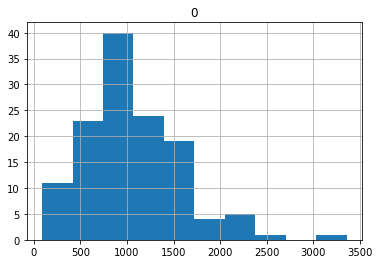

In [334]:
pd.DataFrame(cross_cor).hist()

In [428]:
outcome_df = pd.DataFrame(columns = ['sse_wins','lasso_wins'])


for lasso_penalty in np.linspace(0,2,10):
    single_lambda_df = pd.DataFrame(columns = ['alpha_ses','alpha_lasso','sse_ses','sse_lasso'])

    popular_product_index = sales_data[ sales_data.sum(axis = 1) > 1000].index

    for prod in popular_product_index:
        oos_errors = []
        alphas = []

        Y = sales_data.loc[prod]
        sample_size = len(Y)
        Y_train = Y[0:round(sample_size/2.0)].values
        Y_test = Y[round(sample_size/2.0):sample_size].values
        DY = np.diff(Y_train)
        scale = np.abs(np.sum(DY[:-1] * DY[1:]))
        
        
        train_index = range(0,round(sample_size/2.0))
        test_index = range(round(sample_size/2.0),sample_size)

#         for penalty in [0,  lasso_penalty]:
        for penalty in [0, scale*lasso_penalty]:
            train_alpha = minimal_alpha(Y_test, penalty, 100)
            alphas.append(train_alpha)

            exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
            exp_df['exp'] = exp_df['exp'].shift(1) 
            exp_df = exp_df.reset_index()
            test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

            alpha_list.append(train_alpha)
            oos_errors.append(test_sse)

        single_lambda_df.loc[prod] = alphas + oos_errors
        
    sse_wins = (1*(single_lambda_df['sse_ses'] < single_lambda_df['sse_lasso'])).sum()/len(single_lambda_df)
    lasso_wins = (1*(single_lambda_df['sse_ses'] > single_lambda_df['sse_lasso'])).sum()/len(single_lambda_df)
    outcome_df.loc[lasso_penalty] = [sse_wins, lasso_wins]

Text(0.5, 0, 'Lambda')

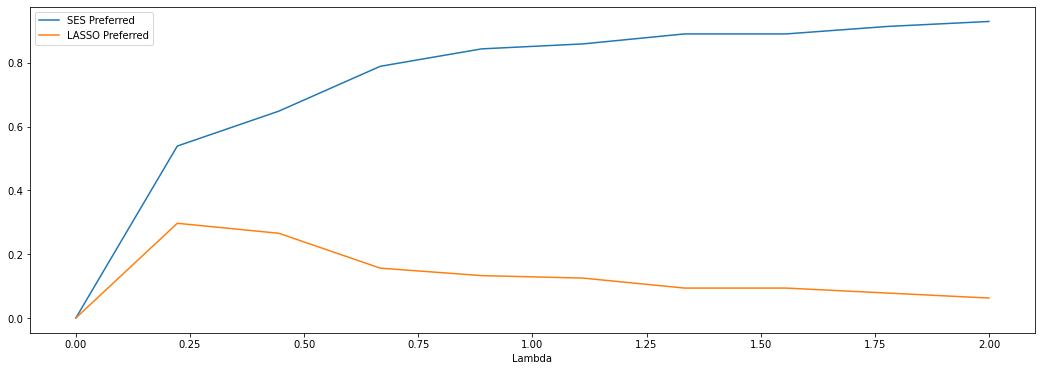

In [429]:
fig, ax = plt.subplots(figsize = (18,6))
outcome_df.plot(ax = ax)
ax.legend(['SES Preferred', 'LASSO Preferred'])
ax.set_xlabel('Lambda')

In [396]:
outcome_df

,sse_wins,lasso_wins
0.000000,0.000000,0.000000
0.005263,0.039062,0.125000
0.010526,0.093750,0.195312
0.015789,0.148438,0.226562
0.021053,0.226562,0.234375
0.026316,0.257812,0.257812
0.031579,0.273438,0.289062
0.036842,0.296875,0.320312
0.042105,0.304688,0.328125
0.047368,0.312500,0.320312


In [422]:
single_lambda_df = pd.DataFrame(columns = ['alpha_ses','alpha_lasso','sse_ses','sse_lasso'])

popular_product_index = sales_data[ sales_data.sum(axis = 1) > 1000].index

for prod in popular_product_index:
    oos_errors = []
    alphas = []

    Y = sales_data.loc[prod]
    sample_size = len(Y)
    Y_train = Y[0:round(sample_size/2.0)].values
    Y_test = Y[round(sample_size/2.0):sample_size].values
    DY = np.diff(Y_train)
    scale = np.abs(np.sum(DY[:-1] * DY[1:]))


    train_index = range(0,round(sample_size/2.0))
    test_index = range(round(sample_size/2.0),sample_size)

#         for penalty in [0,  lasso_penalty]:
    for penalty in [0, scale*.1]:
        train_alpha = minimal_alpha(Y_test, penalty, 100)
        alphas.append(train_alpha)

        exp_df = pd.DataFrame({'Y':Y,'exp':exp_smooth(Y,train_alpha)})
        exp_df['exp'] = exp_df['exp'].shift(1) 
        exp_df = exp_df.reset_index()
        test_sse = np.square(exp_df.loc[test_index]['Y'] - exp_df.loc[test_index]['exp']).sum()

        alpha_list.append(train_alpha)
        oos_errors.append(test_sse)

    single_lambda_df.loc[prod] = alphas + oos_errors

sse_wins = (1*(single_lambda_df['sse_ses'] < single_lambda_df['sse_lasso'])).sum()/len(single_lambda_df)
lasso_wins = (1*(single_lambda_df['sse_ses'] > single_lambda_df['sse_lasso'])).sum()/len(single_lambda_df)

In [423]:
single_lambda_df['delta'] = (single_lambda_df['sse_ses'] - single_lambda_df['sse_lasso'])/single_lambda_df['sse_ses']
single_lambda_df['delta'].median()

0.0

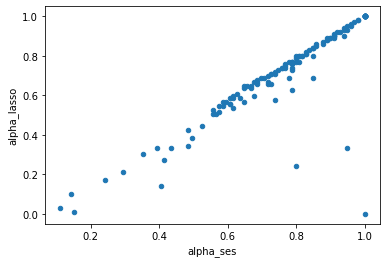

In [424]:
single_lambda_df.plot.scatter(x='alpha_ses',y='alpha_lasso')

0.359375